
# ADS 505 — Team Technical Notebook (Cleaned + Results Summary + Profit Table)

**GitHub repository:** (add your team repo link here)  
**Dataset:** Vehicle Insurance (train.csv, test.csv, sample_submission.csv)  
**Audience:** technical peers. Comments are short and human.

What's new:
- Robust data-quality audit & cleaning (hidden nulls -> NaN, trim, numeric coercion, drop dupes).
- Results summary cell under metrics (plain English).
- Profit table helper to turn Top-K into dollars for your 2-week A/B.


## 1) Problem statement & justification
Goal: Rank customers by probability of purchasing vehicle insurance so the business can contact only the top-K% each day and improve ROI.

Why this matters: Outreach has a cost and limited capacity. Ordering by risk focuses effort where it pays off.


## 2) Setup & raw data load

In [1]:
!pip install -r requirements.txt

In [2]:
import warnings, os, numpy as np, pandas as pd, matplotlib.pyplot as plt, re
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
pd.set_option('display.max_columns', 120)

TRAIN_PATH = 'train.csv'
TEST_PATH  = 'test.csv'
SUB_PATH   = 'sample_submission.csv'

train_raw = pd.read_csv(TRAIN_PATH)
test_raw  = pd.read_csv(TEST_PATH)
sub       = pd.read_csv(SUB_PATH)

# Identify target
target_col = 'Response' if 'Response' in train_raw.columns else train_raw.columns[-1]

print('Raw shapes -> train:', train_raw.shape, '| test:', test_raw.shape, '| sub:', sub.shape)
print('Target column:', target_col)
display(train_raw.head())


Raw shapes -> train: (381109, 12) | test: (127037, 11) | sub: (127037, 2)
Target column: Response


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 3) Data-quality audit (pre-clean)

In [3]:

def dq_audit(df, name='df'):
    print(f"\n=== Data Quality Audit: {name} ===")
    print("Shape:", df.shape)
    print("Dtypes (count):\n", df.dtypes.value_counts())
    miss = df.isna().sum().sort_values(ascending=False)
    print("\nMissing (NaN) — top 15:\n", miss.head(15))

    NULL_LIKE = {"", " ", "NA", "N/A", "na", "n/a", "NaN", "nan", "NULL", "Null", "null", "?", "Unknown", "UNKNOWN", "unknown"}
    counts = {}
    for c in df.columns:
        if df[c].dtype == 'O':
            vc = df[c].isin(NULL_LIKE).sum()
            if vc:
                counts[c] = int(vc)
    if counts:
        print("\nHidden-null tokens (count per column):", counts)
    else:
        print("\nHidden-null tokens: none detected in object columns.")
    dups = df.duplicated().sum()
    print("Duplicate rows:", dups)
    return miss

_ = dq_audit(train_raw, "train (raw)")
_ = dq_audit(test_raw,  "test (raw)")



=== Data Quality Audit: train (raw) ===
Shape: (381109, 12)
Dtypes (count):
 int64      6
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Hidden-null tokens: none detected in object columns.
Duplicate rows: 0

=== Data Quality Audit: test (raw) ===
Shape: (127037, 11)
Dtypes (count):
 int64      5
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintag

## 4) Cleaning: standardize hidden nulls, trim, coerce numerics, drop dupes

In [4]:

NULL_LIKE = {"", " ", "NA", "N/A", "na", "n/a", "NaN", "nan", "NULL", "Null", "null", "?", "Unknown", "UNKNOWN", "unknown"}

def looks_numeric_series(s: pd.Series, sample_n=50):
    s = s.dropna().astype(str)
    if s.empty: 
        return False
    sample = s.sample(min(sample_n, len(s)), random_state=42)
    noise = sample.str.replace(r"[0-9\.\-]", "", regex=True).str.len().mean()
    return noise < 0.2

def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    obj_cols = df.select_dtypes(include=['object']).columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()

    for c in obj_cols:
        df.loc[df[c].isin(NULL_LIKE), c] = np.nan

    obj_as_num = [c for c in obj_cols if looks_numeric_series(df[c])]
    for c in obj_as_num:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    df = df.drop_duplicates(ignore_index=True)
    return df

train = clean_df(train_raw)
test  = clean_df(test_raw)

print("After cleaning shapes -> train:", train.shape, "| test:", test.shape)


After cleaning shapes -> train: (381109, 12) | test: (127037, 11)


## 5) Data-quality audit (post-clean)

In [5]:

_ = dq_audit(train, "train (clean)")
_ = dq_audit(test,  "test (clean)")



=== Data Quality Audit: train (clean) ===
Shape: (381109, 12)
Dtypes (count):
 int64      6
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Hidden-null tokens: none detected in object columns.
Duplicate rows: 0

=== Data Quality Audit: test (clean) ===
Shape: (127037, 11)
Dtypes (count):
 int64      5
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vi

### Optional sanity checks (domain-specific)

In [6]:

def sanity_checks(df):
    issues = {}
    def flag(col, cond, msg):
        n = cond.sum()
        if n:
            issues.setdefault(col, []).append((msg, int(n)))

    cols = df.columns
    if "Age" in cols and pd.api.types.is_numeric_dtype(df["Age"]):
        flag("Age", (df["Age"] < 0) | (df["Age"] > 120), "Age out of range")
    if "Vintage" in cols and pd.api.types.is_numeric_dtype(df["Vintage"]):
        flag("Vintage", df["Vintage"] < 0, "Vintage negative")
    if "Annual_Premium" in cols and pd.api.types.is_numeric_dtype(df["Annual_Premium"]):
        flag("Annual_Premium", df["Annual_Premium"] <= 0, "Premium non-positive")
    if "Previously_Insured" in cols and pd.api.types.is_numeric_dtype(df["Previously_Insured"]):
        flag("Previously_Insured", ~df["Previously_Insured"].isin([0,1]), "Expected 0/1")
    if "Vehicle_Age" in cols and df["Vehicle_Age"].dtype == "O":
        allowed = {"< 1 Year", "1-2 Year", "> 2 Years"}
        flag("Vehicle_Age", ~df["Vehicle_Age"].isin(allowed), "Unexpected category")

    if issues:
        print("\nSanity check issues (column -> [(issue, count)]):")
        for k,v in issues.items():
            print(f"  {k}: {v}")
    else:
        print("\nSanity checks: no obvious issues.")

sanity_checks(train)



Sanity checks: no obvious issues.


## 6) Save cleaned files (reproducible inputs for pipeline)

In [7]:

train.to_csv("train_clean.csv", index=False)
test.to_csv("test_clean.csv", index=False)
print("Saved: train_clean.csv, test_clean.csv")


Saved: train_clean.csv, test_clean.csv


## 7) Quick EDA on cleaned data

Target rate (clean): 0.1226


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


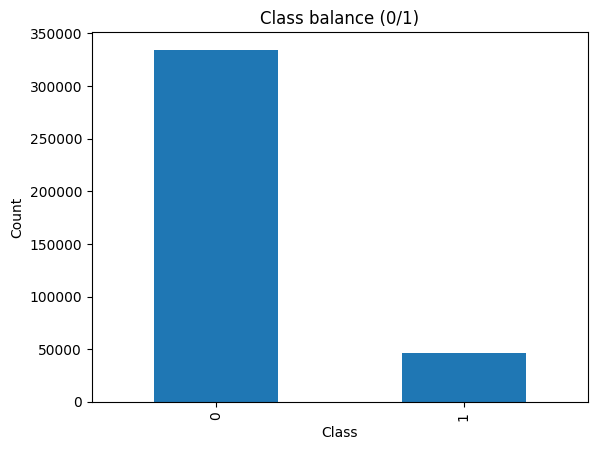

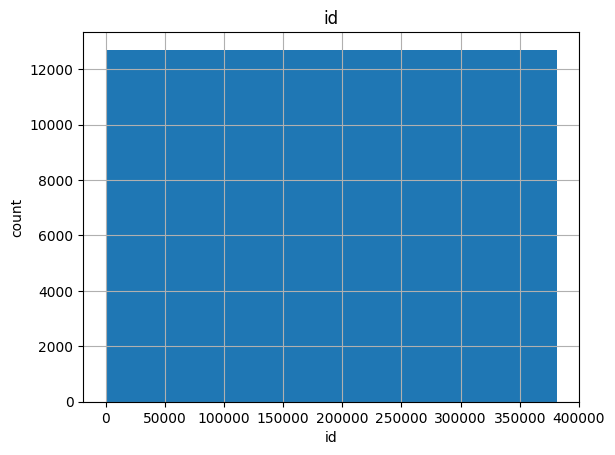

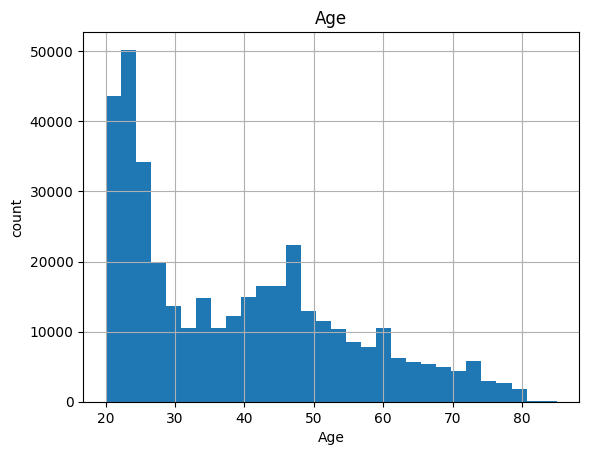

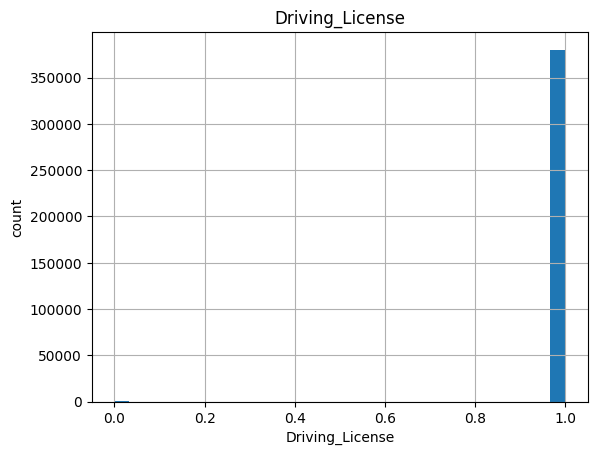

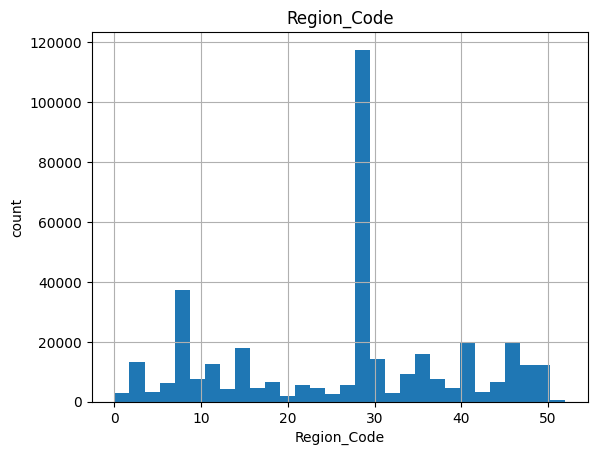

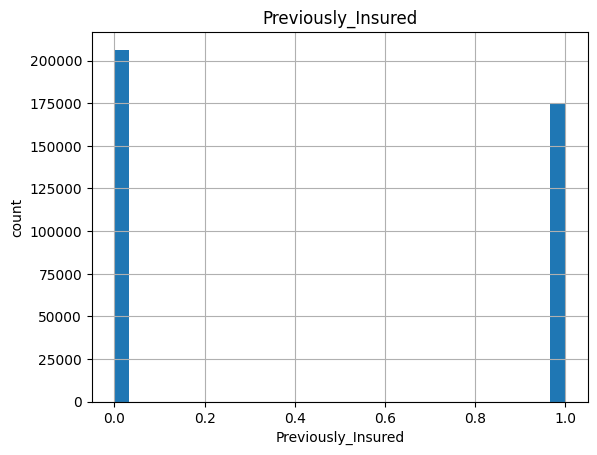

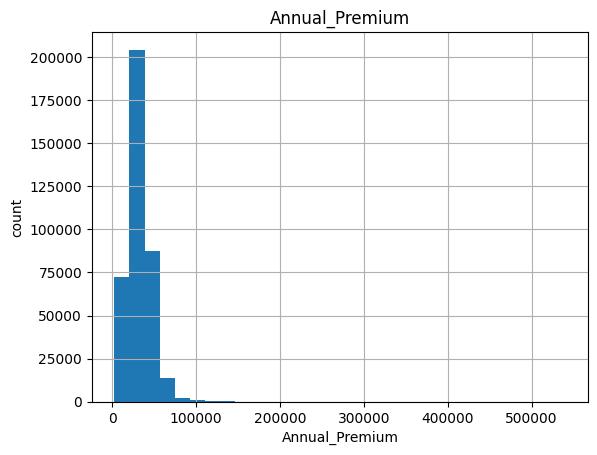

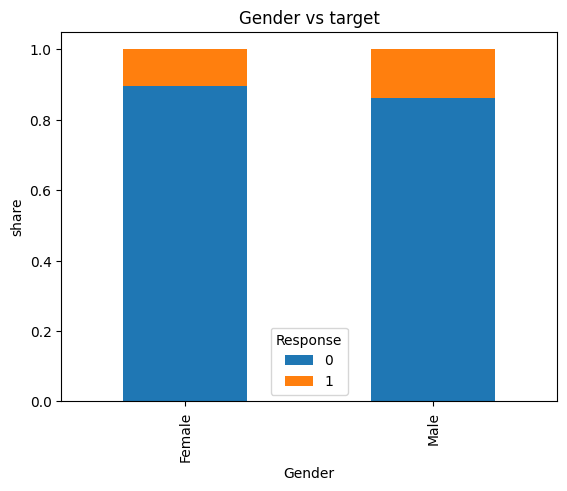

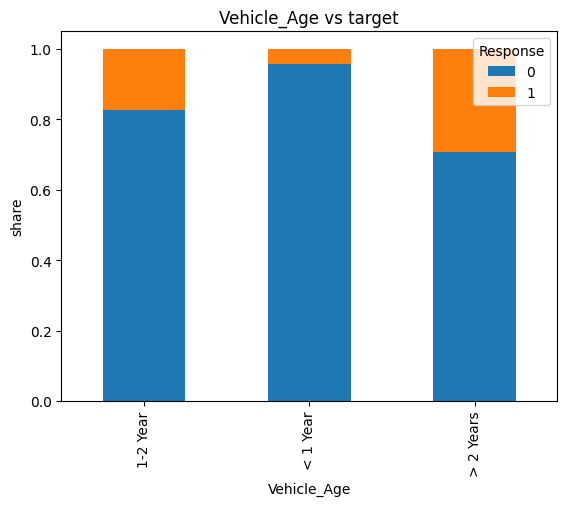

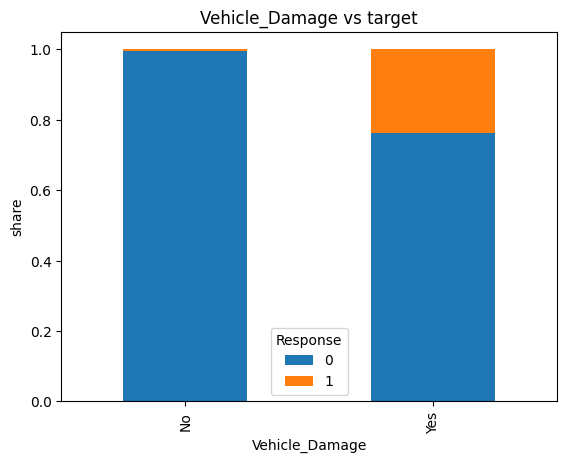

In [8]:

y = train[target_col]
X = train.drop(columns=[target_col])

print('Target rate (clean):', round(y.mean(), 4))
display(train.head())

y.value_counts().plot(kind='bar'); plt.title('Class balance (0/1)'); plt.xlabel('Class'); plt.ylabel('Count'); plt.show()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols[:6]:
    X[col].hist(bins=30); plt.title(col); plt.xlabel(col); plt.ylabel('count'); plt.show()

cat_cols = [c for c in X.columns if c not in num_cols]
for col in cat_cols[:4]:
    tmp = pd.crosstab(X[col], y, normalize='index')
    tmp.plot(kind='bar', stacked=True); plt.title(f'{col} vs target'); plt.ylabel('share'); plt.show()


## 8) Preprocessing pipeline (impute + scale + one-hot)

In [9]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False)),
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe),
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
])

print('Numeric:', len(num_cols), '| Categorical:', len(cat_cols))


Numeric: 8 | Categorical: 3


## 9) Train/validation split (stratified)

In [10]:

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train/Val shapes:', X_train.shape, X_val.shape)
print('Target rate (train/val):', round(y_train.mean(),4), round(y_val.mean(),4))


Train/Val shapes: (304887, 11) (76222, 11)
Target rate (train/val): 0.1226 0.1226


## 10) Model strategies & evaluation

### STILL NEEDS ANSWER
Research questions
- Which baseline gives the best ranking by AUC / PR-AUC?
- For realistic capacity, what Top-K% cutoff gives the best lift?
- Are probabilities well-calibrated (optional later)?


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import numpy as np

def metric_summary(y_true, proba, thr=0.5):
    y_pred = (proba >= thr).astype(int)
    return {
        "AUC":  roc_auc_score(y_true, proba),
        "PR":   average_precision_score(y_true, proba),
        "F1@0.5": f1_score(y_true, y_pred),
        "Acc@0.5": accuracy_score(y_true, y_pred),
    }

def top_k_capture(y_true, proba, k=0.2):
    n = len(y_true); top_n = max(1, int(k*n))
    order = np.argsort(-proba)
    cap = np.sum(np.asarray(y_true)[order][:top_n]) / max(1, np.sum(y_true))
    lift = cap / k
    return cap, lift

models = {
    'LogReg': LogisticRegression(max_iter=200, class_weight='balanced', random_state=42),
    'RF':     RandomForestClassifier(n_estimators=300, min_samples_split=10,
                                     min_samples_leaf=3, class_weight='balanced_subsample',
                                     n_jobs=-1, random_state=42),
    'GB':     GradientBoostingClassifier(random_state=42),
}

best_name, best_auc, best_proba, best_lifts, best_model = None, -np.inf, None, {}, None
lift_at = [0.10, 0.20, 0.30]

for name, clf in models.items():
    pipe = Pipeline([('pre', preprocess), ('clf', clf)]).fit(X_train, y_train)
    proba = pipe.predict_proba(X_val)[:, 1]
    metrics = metric_summary(y_val, proba)

    model_lifts = {k: top_k_capture(y_val, proba, k) for k in lift_at}
    print(name, metrics)
    for k in lift_at:
        cap, lift = model_lifts[k]
        print(f"  Lift@{int(k*100)}%: {lift:.2f}x (captures {cap:.1%} of buyers)")

    # ---- select winner by AUC and SAVE THE PIPELINE ----
    if metrics['AUC'] > best_auc:
        best_auc = metrics['AUC']
        best_name = name
        best_proba = proba
        best_lifts = model_lifts
        best_model = pipe     # <<< THIS WAS MISSING

print(f"\nSelected candidate by AUC: {best_name} | AUC = {best_auc:.4f}")

LogReg {'AUC': np.float64(0.8385069015502351), 'PR': np.float64(0.3225951024202755), 'F1@0.5': np.float64(0.399262818403212), 'Acc@0.5': 0.6407730051691113}
  Lift@10%: 2.90x (captures 29.0% of buyers)
  Lift@20%: 2.73x (captures 54.6% of buyers)
  Lift@30%: 2.51x (captures 75.3% of buyers)
RF {'AUC': np.float64(0.8513079820873781), 'PR': np.float64(0.35178515348729705), 'F1@0.5': np.float64(0.44237657398175845), 'Acc@0.5': 0.8018813465928472}
  Lift@10%: 3.06x (captures 30.6% of buyers)
  Lift@20%: 2.84x (captures 56.8% of buyers)
  Lift@30%: 2.59x (captures 77.7% of buyers)
GB {'AUC': np.float64(0.8562356824571136), 'PR': np.float64(0.3625575425827537), 'F1@0.5': np.float64(0.000213903743315508), 'Acc@0.5': 0.8773582430269476}
  Lift@10%: 3.17x (captures 31.7% of buyers)
  Lift@20%: 2.90x (captures 58.0% of buyers)
  Lift@30%: 2.63x (captures 78.9% of buyers)

Selected candidate by AUC: GB | AUC = 0.8562


## 11) Results summary (plain English)

In [16]:

pos_rate = y_val.mean()
print(f"Best ranker: {best_name} (ROC-AUC {best_auc:.4f}). Buyers in validation ~ {pos_rate:.2%}.")
for k in [0.10, 0.20, 0.30]:
    if k in best_lifts:
        cap, lift = best_lifts[k]
        print(f"Top {int(k*100)}% captures ~{cap:.1%} of buyers (~{lift:.2f}x random).")


Best ranker: GB (ROC-AUC 0.8562). Buyers in validation ~ 12.26%.
Top 10% captures ~31.7% of buyers (~3.17x random).
Top 20% captures ~58.0% of buyers (~2.90x random).
Top 30% captures ~78.9% of buyers (~2.63x random).


In [17]:
# Restart guard: rebuild split + load saved pipeline if best_model not in memory
from pathlib import Path
import joblib, pandas as pd
from sklearn.model_selection import train_test_split

if 'best_model' not in globals():
    RANDOM_STATE = 42
    TARGET = "Response"
    df = pd.read_csv("train.csv")          # or your cleaned file
    X = df.drop(columns=[TARGET]); y = df[TARGET].astype(int)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    best_model = joblib.load(Path("artifacts/final_pipeline.joblib"))
    best_name = best_model.named_steps["clf"].__class__.__name__

### Feature importance export

In [18]:
from sklearn.inspection import permutation_importance
from pathlib import Path
import numpy as np
import pandas as pd

# Use your already-selected best model; if you stored the winner name, reuse it
# Assumes you have: preprocess, X_train, y_train, X_val, y_val defined
# and a pipeline named best_model (Pipeline(preprocess, clf))
try:
    best_model
except NameError:
    raise RuntimeError("best_model not found. Train/select the final pipeline first.")

# 1) Permutation importance on validation
perm = permutation_importance(
    best_model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
)

# 2) Get feature names that MATCH the transformed matrix width
pre = best_model.named_steps["pre"]

def get_feature_names(preprocessor):
    """Return combined numeric + one-hot names in correct order."""
    # Preferred (sklearn >=1.1): one call gets everything
    try:
        names = preprocessor.get_feature_names_out()
        return names.tolist()
    except Exception:
        pass

    # Fallback: build manually
    # transformers_: [('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)]
    num_cols = preprocessor.transformers_[0][2]
    cat_cols = preprocessor.transformers_[1][2]

    # OneHotEncoder might be at 'ohe' step
    try:
        ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    except Exception:
        ohe = preprocessor.named_transformers_["cat"]

    try:
        cat_names = ohe.get_feature_names_out(cat_cols)
    except Exception:
        # Last resort: use raw names if OHE doesn’t expose categories
        cat_names = np.array([f"{c}__encoded" for c in cat_cols])

    return list(num_cols) + list(cat_names)

feature_names = get_feature_names(pre)

# 3) Guard against any mismatch by trimming to the permutation vector length
n_imp = perm.importances_mean.shape[0]
if len(feature_names) != n_imp:
    # Keep them aligned without crashing
    feature_names = feature_names[:n_imp]

# 4) Build tidy frame and save
imp_df = (
    pd.DataFrame(
        {
            "feature": feature_names,
            "importance_mean": perm.importances_mean,
            "importance_std": perm.importances_std,
        }
    )
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

Path("artifacts").mkdir(exist_ok=True)
imp_df.to_csv("artifacts/feature_importance.csv", index=False)
print("Saved -> artifacts/feature_importance.csv")
imp_df.head(15)

Saved -> artifacts/feature_importance.csv


,feature,importance_mean,importance_std
0,num__Region_Code,0.000000,0.000000
1,num__id,-0.000001,0.000009
2,num__Policy_Sales_Channel,-0.000013,0.000019
3,num__Annual_Premium,-0.000024,0.000005
4,cat__Gender_Female,-0.000029,0.000025
5,cat__Vehicle_Age_1-2 Year,-0.000034,0.000016
6,num__Age,-0.000035,0.000026
7,num__Vintage,-0.000038,0.000007
8,num__Previously_Insured,-0.000045,0.000035
9,num__Driving_License,-0.000052,0.000025


### Metrics bundle (save to artifacts/metrics.json)

In [19]:
from pathlib import Path
import json
import math
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

# Helper: lift at top-k fraction
def lift_at_k(y_true, y_score, k=0.1):
    n = len(y_true)
    top_n = max(1, int(math.ceil(k * n)))
    order = np.argsort(-y_score)
    top_true = np.asarray(y_true)[order][:top_n]
    base_rate = np.mean(y_true)
    return float(np.mean(top_true) / base_rate) if base_rate > 0 else float("nan")

# Optional: bootstrap CIs (kept moderate for speed)
def bootstrap_ci(metric_fn, y_true, y_score, n_boot=400, alpha=0.05, **kwargs):
    rng = np.random.default_rng(42)
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    n = len(y_true)
    vals = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        vals.append(float(metric_fn(y_true[idx], y_score[idx], **kwargs)))
    lo = float(np.quantile(vals, alpha/2))
    hi = float(np.quantile(vals, 1 - alpha/2))
    return float(np.mean(vals)), lo, hi

# Use your fitted best pipeline
proba_val = best_model.predict_proba(X_val)[:, 1]
base_rate = float(np.mean(y_val))

roc = float(roc_auc_score(y_val, proba_val))
pr  = float(average_precision_score(y_val, proba_val))

# Lifts
lift10 = lift_at_k(y_val, proba_val, k=0.10)
lift20 = lift_at_k(y_val, proba_val, k=0.20)
lift30 = lift_at_k(y_val, proba_val, k=0.30)

# CIs (comment out if you want it even faster)
roc_m, roc_lo, roc_hi = bootstrap_ci(lambda y,t: roc_auc_score(y,t), y_val, proba_val)
pr_m,  pr_lo,  pr_hi  = bootstrap_ci(lambda y,t: average_precision_score(y,t), y_val, proba_val)
l10_m, l10_lo, l10_hi = bootstrap_ci(lift_at_k, y_val, proba_val, k=0.10)
l20_m, l20_lo, l20_hi = bootstrap_ci(lift_at_k, y_val, proba_val, k=0.20)
l30_m, l30_lo, l30_hi = bootstrap_ci(lift_at_k, y_val, proba_val, k=0.30)

summary = {
    "model_name": best_model.named_steps["clf"].__class__.__name__,
    "base_rate": base_rate,
    "roc_auc": {"value": roc, "bootstrap_mean": roc_m, "ci_low": roc_lo, "ci_high": roc_hi},
    "pr_auc":  {"value": pr,  "bootstrap_mean": pr_m,  "ci_low": pr_lo,  "ci_high": pr_hi},
    "lift": {
        "top10": {"value": lift10, "bootstrap_mean": l10_m, "ci_low": l10_lo, "ci_high": l10_hi},
        "top20": {"value": lift20, "bootstrap_mean": l20_m, "ci_low": l20_lo, "ci_high": l20_hi},
        "top30": {"value": lift30, "bootstrap_mean": l30_m, "ci_low": l30_lo, "ci_high": l30_hi},
    },
}

Path("artifacts").mkdir(exist_ok=True)
with open("artifacts/metrics.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved metrics to artifacts/metrics.json")
print(
    f"AUC={roc:.4f}, PR-AUC={pr:.4f}, base_rate={base_rate:.2%}; "
    f"lift@10={lift10:.2f}x, @20={lift20:.2f}x, @30={lift30:.2f}x"
)

Exception ignored in: <function ResourceTracker.__del__ at 0x10aac62a0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x108f262a0>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versi

✅ Saved metrics to artifacts/metrics.json
AUC=0.8562, PR-AUC=0.3626, base_rate=12.26%; lift@10=3.17x, @20=2.90x, @30=2.63x


### Lift chart + table (saved to artifacts)

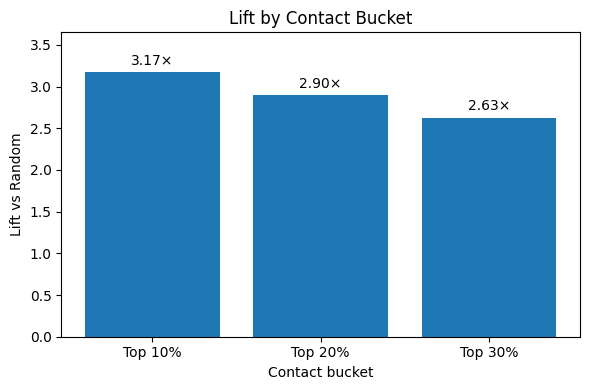

Saved -> artifacts/lift_table.csv and artifacts/lift_chart.png


,bucket,capture,lift
0,Top 10%,0.317491,3.174909
1,Top 20%,0.579854,2.899272
2,Top 30%,0.788803,2.629344


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

Path("artifacts").mkdir(exist_ok=True)

# If you still have proba and y_val in memory from Step 2, reuse them.
# Otherwise, recompute:
proba_val = best_model.predict_proba(X_val)[:, 1]

def capture_at_k(y_true, y_score, k):
    n = len(y_true)
    top_n = max(1, int(np.ceil(k * n)))
    order = np.argsort(-y_score)
    hits = np.asarray(y_true)[order][:top_n].sum()
    cap = hits / max(1, np.sum(y_true))  # share of all buyers captured
    lift = cap / k
    return float(cap), float(lift)

rows = []
for k in (0.10, 0.20, 0.30):
    cap, lift = capture_at_k(y_val, proba_val, k)
    rows.append({"bucket": f"Top {int(k*100)}%", "capture": cap, "lift": lift})

lift_df = pd.DataFrame(rows)
lift_df.to_csv("artifacts/lift_table.csv", index=False)

# Plot
plt.figure(figsize=(6,4))
plt.bar(lift_df["bucket"], lift_df["lift"])
for i, v in enumerate(lift_df["lift"]):
    plt.text(i, v + 0.05, f"{v:.2f}×", ha="center", va="bottom", fontsize=10)
plt.title("Lift by Contact Bucket")
plt.ylabel("Lift vs Random")
plt.xlabel("Contact bucket")
plt.ylim(0, max(lift_df["lift"])*1.15)
plt.tight_layout()
plt.savefig("artifacts/lift_chart.png", dpi=200)
plt.show()

print("Saved -> artifacts/lift_table.csv and artifacts/lift_chart.png")
lift_df

### Save final model pipeline and confirm path

In [21]:
from pathlib import Path
import joblib

# Refit the best model on all data for deployment
best_model.fit(X, y)

Path("artifacts").mkdir(exist_ok=True)
model_path = Path("artifacts/final_pipeline.joblib")

joblib.dump(best_model, model_path)

print(f"Final model saved to: {model_path.resolve()}")

Final model saved to: /Users/Jordan/Documents/USD/Fall 2025/ADS 505/final/ADS-505/artifacts/final_pipeline.joblib


### Verify saved pipeline loads and predicts correctly

In [22]:
import joblib
import numpy as np

# Path to the saved model
model_path = "artifacts/final_pipeline.joblib"

# Load it back
loaded_model = joblib.load(model_path)
print(f"Model loaded successfully from {model_path}")

# Sanity check: predict on a small sample
sample_idx = np.random.choice(len(X_val), size=5, replace=False)
X_sample = X_val.iloc[sample_idx]
y_sample = y_val.iloc[sample_idx]

preds = loaded_model.predict_proba(X_sample)[:, 1]
print("\nSample predictions:")
for i, p in enumerate(preds):
    print(f"  Row {sample_idx[i]} → Prob: {p:.3f}, Actual: {y_sample.iloc[i]}")

Model loaded successfully from artifacts/final_pipeline.joblib

Sample predictions:
  Row 37052 → Prob: 0.002, Actual: 0
  Row 60142 → Prob: 0.167, Actual: 0
  Row 67423 → Prob: 0.101, Actual: 0
  Row 53078 → Prob: 0.055, Actual: 0
  Row 14115 → Prob: 0.002, Actual: 0


Exception ignored in: <function ResourceTracker.__del__ at 0x10b5c6200>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106b56200>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versi

## 12) Streamlit
### Self-contained app that loads the saved pipeline and offers a clean UI.


In [32]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path

MODEL_PATH = Path("artifacts/final_pipeline.joblib")
METRICS_PATH = Path("artifacts/metrics.json")
FI_PATH = Path("artifacts/feature_importance.csv")
LIFT_IMG = Path("artifacts/lift_chart.png")

@st.cache_resource(show_spinner=False)
def load_pipeline_safe():
    """Safely load the trained scikit-learn pipeline."""
    try:
        if not MODEL_PATH.exists():
            st.error(f"❌ Model not found at {MODEL_PATH}")
            st.stop()
        model = joblib.load(MODEL_PATH)
        if model is None:
            st.error("❌ Model file exists but failed to load properly.")
            st.stop()
        st.sidebar.success("Model loaded successfully!")
        return model
    except Exception as e:
        st.error(f"⚠️ Error loading pipeline: {e}")
        st.stop()

pipe = load_pipeline_safe()

def get_schema_from_pipeline(pipeline):
    """Return ordered numeric and categorical column names and OHE categories."""
    pre = pipeline.named_steps["pre"]
    num_cols, cat_cols, cat_categories = [], [], {}

    # transformers_: [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols), ...]
    for name, transformer, cols in pre.transformers_:
        if name == "num":
            num_cols = list(cols)
        elif name == "cat":
            cat_cols = list(cols)
            try:
                ohe = pre.named_transformers_["cat"].named_steps["onehot"]
            except Exception:
                ohe = pre.named_transformers_["cat"]
            if hasattr(ohe, "categories_"):
                for c, cats in zip(cat_cols, ohe.categories_):
                    cat_categories[c] = list(map(str, cats))
    return num_cols, cat_cols, cat_categories

def predict_one_row(pipeline, row_dict: dict):
    if pipeline is None:
        st.error("Model pipeline not loaded — please restart the app.")
        st.stop()
    df = pd.DataFrame([row_dict])
    if hasattr(pipeline, "predict_proba"):
        proba = float(pipeline.predict_proba(df)[:, 1][0])
    elif hasattr(pipeline, "decision_function"):
        s = float(pipeline.decision_function(df)[0])
        proba = 1 / (1 + np.exp(-s))
    else:
        proba = float(pipeline.predict(df)[0])
    pred = int(proba >= 0.5)
    return proba, pred

def score_csv(pipeline, file):
    df = pd.read_csv(file)
    df["_score"] = pipeline.predict_proba(df)[:, 1]
    return df

# --- UI starts here ---
st.title("Vehicle Insurance Propensity — Team LJV")
st.write("Predict the likelihood a customer will purchase vehicle insurance. This demo uses the saved pipeline trained in the notebook.")

# 🔹 Get schema from pipeline (for UI controls)
num_cols, cat_cols, cat_categories = get_schema_from_pipeline(pipe)

# Tabs: Single prediction | Batch CSV | About
tab1, tab2, tab3 = st.tabs(["Single prediction", "Batch CSV", "About"])

with tab1:
    st.subheader("Enter customer details")
    user_inputs = {}

    if num_cols:
        st.markdown("**Numeric features**")
    for col in num_cols:
        user_inputs[col] = st.number_input(col, value=0.0, step=1.0, format="%.4f")

    if cat_cols:
        st.markdown("**Categorical features**")
    for col in cat_cols:
        choices = cat_categories.get(col, [])
        if choices:
            user_inputs[col] = st.selectbox(col, choices, index=0)
        else:
            user_inputs[col] = st.text_input(col, value="Unknown")

    if st.button("Predict propensity", type="primary"):
        proba, pred = predict_one_row(pipe, user_inputs)
        st.success(f"Predicted probability: **{proba:.3f}**")
        st.write(f"Decision at 0.50 threshold: **{pred}** (1 = likely buyer)")
        st.write("Recommendation: include in today's outreach." if proba >= 0.5
                 else "Recommendation: hold out or include in a lower-priority batch.")

with tab2:
    st.subheader("Upload CSV to score")
    up = st.file_uploader("CSV with the same columns used in training", type=["csv"])
    if up is not None:
        out_df = score_csv(pipe, up)
        st.dataframe(out_df.head(20))
        out_path = "scored_output.csv"
        out_df.to_csv(out_path, index=False)
        with open(out_path, "rb") as f:
            st.download_button("Download scored CSV", f, file_name="scored_output.csv", mime="text/csv")

with tab3:
    st.subheader("About the model")
    if METRICS_PATH.exists():
        metrics = json.loads(METRICS_PATH.read_text())
        base = metrics.get("base_rate", float("nan"))
        roc  = metrics.get("roc_auc", {}).get("value")
        pr   = metrics.get("pr_auc", {}).get("value")
        st.write(f"Base rate: {base:.2%}  |  ROC AUC: {roc:.4f}  |  PR AUC: {pr:.4f}")
        lift = metrics.get("lift", {})
        if lift:
            st.write(
                "Lift Top 10%: {0:.2f}×, Top 20%: {1:.2f}×, Top 30%: {2:.2f}×"
                .format(lift.get('top10',{}).get('value', float('nan')),
                        lift.get('top20',{}).get('value', float('nan')),
                        lift.get('top30',{}).get('value', float('nan')))
            )
    if FI_PATH.exists():
        st.markdown("**Top features (permutation importance)**")
        st.dataframe(pd.read_csv(FI_PATH).head(10))
    if LIFT_IMG.exists():
        st.image(str(LIFT_IMG), caption="Lift by Contact Bucket")

    st.caption("This app uses the final scikit-learn Pipeline saved from the technical notebook.")

st.sidebar.write(f"Model path: {MODEL_PATH}")
st.sidebar.success("Model loaded")

2025-10-13 02:26:11.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-13 02:26:11.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-13 02:26:11.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-13 02:26:11.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-13 02:26:11.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-13 02:26:11.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-13 02:26:11.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-13 02:26:11.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator(_root_container=1, _parent=DeltaGenerator())

## 13) Interpretation (what the outputs mean)


- AUC / PR-AUC show how well the ranking separates likely buyers from non-buyers.
- We select the ranking model by AUC, and choose how many to contact by lift (share of buyers captured at Top-K).
- If Top 20% has high lift (e.g., ~3x), it means you capture a large share of buyers by contacting a small slice.


## 14) Actionable recommendation & next steps (stakeholder-ready)


Action (starting now): Sort the daily list by predicted purchase risk and contact only the top ~20%.
Validation: Run a 2-week A/B test vs business-as-usual. Track net dollars (outreach cost vs conversions).
If on target: keep the process and optionally nudge the cutoff +/-5pp during demand spikes.
If below target: lower the cutoff and re-evaluate. Monitor acceptance weekly and retune quarterly.



### Streamlit launcher (auto-picks a free port and does not block the notebook)

This cell will terminate any previously started Streamlit process from this notebook, pick a free port (8501–8600), launch the app, and open your browser to the correct URL.  
Re-run it any time you want to restart the app.


In [16]:
# --- Streamlit non-blocking launcher (auto-picks free port) ---
import sys, subprocess, socket, time, webbrowser

# Stop any previous process started by this notebook
try:
    st_proc.terminate()  # type: ignore
except Exception:
    pass

def pick_free_port(start=8501, end=8600):
    for p in range(start, end+1):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("127.0.0.1", p))
                return p
            except OSError:
                continue
    return 0  # let Streamlit choose

port = pick_free_port()
cmd = [sys.executable, "-m", "streamlit", "run", "app_vehicle_insurance.py",
       "--server.headless", "true", "--server.port", str(port)]
st_proc = subprocess.Popen(cmd)

url = f"http://localhost:{port}" if port != 0 else "http://localhost:8501"
print("Launching Streamlit:", " ".join(cmd))
print("Open", url)
time.sleep(2)
try:
    webbrowser.open(url)
except Exception:
    pass


Launching Streamlit: /Users/Jordan/Documents/USD/Fall 2025/ADS 505/final/ADS-505/.venv/bin/python -m streamlit run app_vehicle_insurance.py --server.headless true --server.port 8501
Open http://localhost:8501



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.68.53:8501
  External URL: http://24.4.67.164:8501



2025-10-13 00:06:13.418 Uncaught app exception
Traceback (most recent call last):
  File "/Users/Jordan/Documents/USD/Fall 2025/ADS 505/final/ADS-505/.venv/lib/python3.13/site-packages/streamlit/runtime/scriptrunner/exec_code.py", line 88, in exec_func_with_error_handling
    result = func()
  File "/Users/Jordan/Documents/USD/Fall 2025/ADS 505/final/ADS-505/.venv/lib/python3.13/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 590, in code_to_exec
    exec(code, module.__dict__)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/Jordan/Documents/USD/Fall 2025/ADS 505/final/ADS-505/app_vehicle_insurance.py", line 53, in <module>
    proba = float(model.predict(X)[0])
                  ^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'predict'


In [24]:
# --- Stop the Streamlit process started by the launcher ---
try:
    st_proc.terminate()
    print("Streamlit process terminated.")
except Exception as e:
    print("No running Streamlit process found in this notebook session.", e)


Streamlit process terminated.
  Stopping...
